In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import optim
import os
from tqdm.notebook import tqdm
import typing as typ
import pickle
import shutil
import numpy as np
import pandas as pd
from functools import partial
from rich.console import Console
global SEP
SEP = os.sep
cs = Console()

In [2]:
print(
"""
torch   version = {t_version}
numpy   version = {np_version}
pandas  version = {pd_version}
""".format(
    t_version = torch.__version__,
    np_version = np.__version__,
    pd_version = pd.__version__
)
)


torch   version = 1.11.0
numpy   version = 1.21.6
pandas  version = 1.3.5



In [3]:
!ls ../input/pemsbay

adj_mx_bay.pkl	pems-bay-meta.h5  pems-bay.h5


# Paper 
- **Spatial-Temporal Identity: A Simple yet Effective Baseline for Multivariate Time Series Forecasting**
- Paper: https://arxiv.org/abs/2208.05233
- GitHub:(use esayTorch): https://github.com/zezhishao/STID
- DataSet(PEMS-BAY): https://zenodo.org/record/4263971#.Yt5GCOxKj0o

#  &#x1F528; Feature Engineer

In [4]:
def std_transform(data: np.ndarray, output_dir: typ.AnyStr, train_index: typ.List):
    """数据标准化
        data: 原始时序数据
        output_dir: 输出文件名
        train_index: 训练样本的idx
    return:
        np.ndarray: 标准化后的数据
    """
    
    # data: L：数据sample, N, C 
    # train_index[-1][1] 训练idx的最后一个末尾位置
    data_train = data[:train_index[-1][1], ...]
    mean_, std_ = data_train[..., 0].mean(), data_train[..., 0].std()
    print(f'mean (training data): {mean_:.5f}\nstd (training data): {std_:.5f}')
    scaler_ = {}
    scaler_['func'] = std_transform.__name__
    scaler_['args'] = {"mean":mean_, "std":std_}
    pickle.dump(scaler_, open(output_dir + f"{SEP}scaler.pkl", 'wb'))

    def normalize(x): return (x - mean_) / std_
    return normalize(data)


def std_re_transform(x, kwargs):
    mean_, std_ = kwargs['mean'], kwargs['std']
    return x * std_ + mean_


def generate_data(args):
    """数据拆分成 train val test
    """
    C = args.C
    future_seq_len = args.future_seq_len
    history_seq_len = args.history_seq_len
    add_time_in_day = True
    add_day_in_week = args.dow
    output_dir = args.output_dir
    train_ratio = args.train_ratio
    valid_ratio = args.valid_ratio
    # read data (52116, 325)
    df = pd.read_hdf(args.data_file_path)
    display(df.head())
    # (sample: 52116, sensor_id: 325, 1) 
    data = np.expand_dims(df.values, axis=-1)
    data = data[..., C]
    print(data.shape)
    L, N, F = data.shape
    
    num_samples = L - (history_seq_len + future_seq_len)  + 1
    
    train_num_short = round(num_samples * train_ratio)
    valid_num_short = round(num_samples * valid_ratio)
    test_num_short  = num_samples - train_num_short - valid_num_short
    print("train_num_short:{0}".format(train_num_short))
    print("valid_num_short:{0}".format(valid_num_short))
    print("test_num_short:{0}".format(test_num_short))

    index_list = []
    # 数据滑窗构造
    for i in range(history_seq_len, num_samples + history_seq_len):
        index_list.append(
            (i - history_seq_len, i, i + future_seq_len)
        )
    
    train_idx = index_list[:train_num_short]
    vaild_idx = index_list[train_num_short:train_num_short + valid_num_short]
    test_idx = index_list[train_num_short + valid_num_short:train_num_short + valid_num_short + test_num_short]

    # 数据normlize
    data_norm = std_transform(data, output_dir, train_idx)
    print('data_norm.shape: ', data_norm.shape)
    # 增加额外特征
    feature_list = [data_norm]
    if add_time_in_day:
        # 0-1 按秒/(60 * 60 * 24)
        seconds_arr = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        feature_list.append( np.tile(seconds_arr, [1, N, 1]).transpose((2, 1, 0)) )

    if add_day_in_week:
        # 周一至周日 0, 1, 2, 3, 4, 5, 6
        dow = df.index.dayofweek
        feature_list.append( np.tile(dow, [1, N, 1]).transpose((2, 1, 0)) )
    
    # 在左后的channel相连接， [data, time_in_day, day_in_week]
    raw_data = np.concatenate(feature_list, axis=-1)
    # 保存数据
    idx = {
        'train' : train_idx,
        'vaild' : vaild_idx,
        'test' : test_idx
    }
    pickle.dump(idx, open(output_dir + f"{SEP}index.pkl", "wb"))
    print('\n---------------------------------------------\nProcessed Data:')
    cs.print(f'Data Shape: {raw_data.shape} (Samples, N-space, Channel);\nChannel-0: Time Series Data;\nChannel-1: time_in_day;\nChannel-2: Day of Week (0~6)')
    data = {
        'raw_data': raw_data
    }
    pickle.dump(data, open(output_dir + f"{SEP}data.pkl", "wb"))
    # copy model
    shutil.copyfile(args.graph_file_path, output_dir + f"{SEP}adj_mx.pkl")


class FEconfig:
    history_seq_len = 12                    # sliding window size for generating history sequence and target sequence
    future_seq_len  = 12
    train_ratio     = 0.7
    valid_ratio     = 0.1
    C               = [0]                   # selected channels
    dow             = True                  # if add day_of_week feature
    output_dir      = '../working'
    data_file_path  = '../input/pemsbay/pems-bay.h5'
    graph_file_path = '../input/pemsbay/adj_mx_bay.pkl'

In [5]:
args = FEconfig()
print(args.output_dir)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
generate_data(args)

../working


sensor_id,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9


(52116, 325, 1)
train_num_short:36465
valid_num_short:5209
test_num_short:10419
mean (training data): 62.73670
std (training data): 9.43724
data_norm.shape:  (52116, 325, 1)

---------------------------------------------
Processed Data:


Data Shape: (52116, 325, 3) (Samples, N-space, Channel);
Channel-0: Time Series Data;
Channel-1: time_in_day;
Channel-2: Day of Week (0~6)

# &#x2728; Model Struct

In [6]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=(1, 1), bias=True)
        self.fc2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(1, 1), bias=True)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=0.15)
    
    def forward(self, in_data):
        # in_data: [B, D, N]
        out = self.act(self.fc1(in_data))
        out = self.fc2(self.drop(out))
        return out + in_data



class STID_paper(nn.Module):
    def __init__(self, model_kwargs):
        super(STID_paper, self).__init__()
        # attributes
        self.num_nodes = model_kwargs['num_nodes']
        self.node_dim = model_kwargs['node_dim']
        self.input_len = model_kwargs['input_len']
        self.input_dim = model_kwargs['input_dim']
        self.embed_dim = model_kwargs['embed_dim']
        self.output_len = model_kwargs['output_len']
        self.num_layer = model_kwargs['num_layer']
        self.temp_dim_tid = model_kwargs['temp_dim_tid']
        self.temp_dim_diw = model_kwargs['temp_dim_diw']
        
        self.if_time_in_day = model_kwargs['if_T_i_D']
        self.if_day_in_week = model_kwargs['if_D_i_W']
        self.if_spatial = model_kwargs['if_node']
        
        # spatial embeddings
        if self.if_spatial:
            self.node_emb = nn.Parameter(
                torch.empty(self.num_nodes, self.node_dim)
            )
            nn.init.xavier_uniform_(self.node_emb)
        
        # temporal embeddings
        if self.if_time_in_day:
            self.time_in_day_emb = nn.Parameter(
                torch.empty(288, self.temp_dim_tid)
            )
            nn.init.xavier_uniform_(self.time_in_day_emb)
        if self.if_day_in_week:
            self.day_in_week_emb  = nn.Parameter(
                torch.empty(7, self.temp_dim_diw)
            )
            nn.init.xavier_uniform_(self.day_in_week_emb )

        # embedding layer
        self.time_sires_emb_layer = nn.Conv2d(
            self.input_dim * self.input_len, self.embed_dim, kernel_size=(1, 1), bias=True
        )
        # encoding
        self.hidden_dim = self.embed_dim + \
                            self.node_dim * int(self.if_spatial) + \
                            self.temp_dim_tid * int(self.if_time_in_day) + \
                            self.temp_dim_diw * int(self.if_day_in_week)
        self.encoder = nn.Sequential(
            *[MultiLayerPerceptron(self.hidden_dim, self.hidden_dim) for _ in range(self.num_layer)]
        )
        
        # regression
        self.regression_layer = nn.Conv2d(
            self.hidden_dim, self.output_len, kernel_size=(1, 1), bias=True
        )
        
    def forward(self, his_data):
        """Feed forward of STID.
        Args:
            his_data (torch.Tensor): history data with shape [B, L, N, C]
        Returns:
            torch.Tensor: prediction wit shape [B, L, N, C]
        """
        # prepare
        input_data = his_data[..., range(self.input_dim)]
        time_in_day_emb = None
        if self.if_time_in_day:
            t_i_d_data = his_data[..., 1]
            time_in_day_emb = self.time_in_day_emb[
                (t_i_d_data[:, -1, :] * 288).type(torch.LongTensor)
            ]

        day_in_week_emb = None
        if self.if_day_in_week:
            d_i_w_data = his_data[..., 2]
            day_in_week_emb = self.day_in_week_emb[
                (d_i_w_data[:, -1, :]).type(torch.LongTensor)
            ]

        # ts embedding
        batch_size, _, num_nodes, _ = input_data.shape
        input_data = input_data.transpose(1, 2).contiguous()
        input_data = input_data.view(batch_size, num_nodes, -1).transpose(1, 2).unsqueeze(-1)
        time_series_emb = self.time_sires_emb_layer(input_data)

        node_emb = []
        if self.if_spatial:
            node_emb.append(
                self.node_emb.unsqueeze(0).expand(
                    batch_size, -1, -1
                ).transpose(1, 2).unsqueeze(-1)
            )
        # temp embedding
        tem_emb = []
        if self.if_time_in_day:
            tem_emb.append(
                time_in_day_emb.transpose(1, 2).unsqueeze(-1)
            )
        if self.if_day_in_week:
            tem_emb.append(
                day_in_week_emb.transpose(1, 2).unsqueeze(-1)
            )

        # concat
        hidden = torch.cat([time_series_emb] + node_emb + tem_emb, dim=1) 
        # encoding
        hidden = self.encoder(hidden)
        pred = self.regression_layer(hidden)
        return pred[..., 0]

In [7]:
class MyMultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MyMultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(p=0.15)
    
    def forward(self, in_data):
        # in_data: [B, D, N]
        out = self.act(self.fc1(in_data))
        out = self.fc2(self.drop(out))
        return out + in_data


class MYSTID(nn.Module):
    def __init__(self, model_kwargs):
        super(MYSTID, self).__init__()
        # attributes
        self.num_nodes = model_kwargs['num_nodes']
        self.node_dim = model_kwargs['node_dim']
        self.input_len = model_kwargs['input_len']
        self.input_dim = model_kwargs['input_dim']
        self.embed_dim = model_kwargs['embed_dim']
        self.output_len = model_kwargs['output_len']
        self.num_layer = model_kwargs['num_layer']
        self.temp_dim_tid = model_kwargs['temp_dim_tid']
        self.temp_dim_diw = model_kwargs['temp_dim_diw']
        
        self.if_time_in_day = model_kwargs['if_T_i_D']
        self.if_day_in_week = model_kwargs['if_D_i_W']
        self.if_spatial = model_kwargs['if_node']
        self.device = model_kwargs['device']
        
        # # spatial embeddings (nn.init.xavier_uniform_(self.node_emb))
        self.node_emb = nn.Embedding(num_embeddings=self.num_nodes, embedding_dim=self.node_dim)
        # temporal embeddings
        self.time_in_day_emb = nn.Embedding(num_embeddings=288, embedding_dim=self.temp_dim_tid)
        self.day_in_week_emb = nn.Embedding(num_embeddings=7, embedding_dim=self.temp_dim_diw)
        # embedding layer
        self.time_sires_emb_layer = nn.Linear(in_features=self.input_dim * self.input_len, out_features=self.embed_dim, bias=True)
        # encoding
        self.hidden_dim = self.embed_dim + self.node_dim * int(self.if_spatial) + \
                            self.temp_dim_tid * int(self.if_time_in_day) + \
                            self.temp_dim_diw * int(self.if_day_in_week)
        self.encoder = nn.Sequential(
            *[MyMultiLayerPerceptron(self.hidden_dim, self.hidden_dim) for _ in range(self.num_layer)]
        )
        
        # regression
        self.regression_layer = nn.Linear(self.hidden_dim, self.output_len, bias=True)

    def forward(self, his_data):
        """Feed forward of STID.
        Args:
            his_data (torch.Tensor): history data with shape [B, L, N, C]
        Returns:
            torch.Tensor: prediction wit shape [B, L, N, C]
        """
        # prepare
        input_data = his_data[..., range(self.input_dim)]
        time_in_day_emb = None
        if self.if_time_in_day:
            t_i_d_data = (his_data[:, -1, :, 1] * 288).type(torch.LongTensor).to(self.device)
            # (b, node_nums(time_in_day dim-len)) -> T^{TiD}(Nd x D)-> (b, node_nums(time_in_day dim-len), emb)
            time_in_day_emb = self.time_in_day_emb(t_i_d_data)
    
        day_in_week_emb = None
        if self.if_day_in_week:
            d_i_w_data = (his_data[:, -1, :, 2]).type(torch.LongTensor).to(self.device)
            # (b, node_nums(day_in_week dim-len)) -> T^{DiW}(Nw x D)-> (b, node_nums(day_in_week dim-len), emb)
            day_in_week_emb = self.day_in_week_emb(d_i_w_data)

        # ts embedding
        batch_size, _, num_nodes, _ = input_data.shape
        # (b, L, num_nodes, channel) -> (b, num_nodes, L, channel) ->
        # (b, num_nodes, L, channel) -> (b, num_nodes, L * channel) (data || time-in-day || day-of-week)
        input_data = input_data.transpose(1, 2).contiguous()
        input_data = input_data.view(batch_size, num_nodes, -1)
        # (b, num_nodes, L * channel) -> FC_emb (L*channel, D) -> (b, num_nodes, emb) 
        time_series_emb = self.time_sires_emb_layer(input_data)

        # node emb
        # (b, node_nums)
        nodes_indx = torch.Tensor([list(range(num_nodes)) for _ in range(batch_size)]).long().to(self.device)
        node_emb = []
        if self.if_spatial:
            node_emb.append(
                # (b, node_nums) -> E(N x D) -> (b, node_nums, emb)
                self.node_emb(nodes_indx)
            )

        # time embedding
        tem_emb = []
        if self.if_time_in_day:
            tem_emb.append( time_in_day_emb )
        if self.if_day_in_week:
            tem_emb.append( day_in_week_emb )
        
        # concat (b, num_node, 32*4)
        hidden = torch.cat([time_series_emb] + node_emb + tem_emb, dim=2)
        # (b, num_node, 32*4) -> (b, num_node, 32*4)
        hidden = self.encoder(hidden)
        # (b, num_node, 32*4) -> (b, num_node, out_len)
        pred = self.regression_layer(hidden)
        # print('pred - pred.shape:', pred.shape)
        return pred.transpose(1, 2).contiguous()

# &#x1f4cc; Some Utils
- DataLoader
- Config

In [8]:

class runConfig:
    DATASET_NAME  = "PEMS-BAY"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    model_param = {
        "num_nodes" : 325, 
        'input_len' : 12,
        'input_dim' : 3,
        'embed_dim' : 32,
        'output_len': 12,
        'num_layer' : 3,
        "if_node"   : True,
        'node_dim'  : 32,
        "if_T_i_D"  : True,
        "if_D_i_W"  : True,
        'temp_dim_tid': 32,
        'temp_dim_diw': 32,
        'device': device,
    }
    
    forward_features = [0, 1, 2]
    target_features = [0]
    opt_name = 'Adam'
    opt_param = {
        'lr': 0.002,
        'weight_decay': 0.0001
    }
    
    MultiStepLR_param = {
        "milestones":[1, 50, 80],
        "gamma":0.5
    }

    num_epoches = 100
    ckpt_save_file = os.path.join(
       '../working/checkpoints', f'STID_{num_epoches}.ckpt'
    )
    # train data
    NULL_VAL      = 0.0
    ## read data
    DATA_DIR      = '../working'
    data_file      = '../working/data.pkl'
    index_file      = '../working/index.pkl'
    scaler_file      = '../working/scaler.pkl'
    ## dataloader args, optional
    tr_BATCH_SIZE   = 32
    tr_PREFETCH     = False
    tr_SHUFFLE      = True
    tr_NUM_WORKERS  = 2
    tr_PIN_MEMORY   = False

    val_BATCH_SIZE     = 64
    val_PREFETCH       = False
    val_SHUFFLE        = False
    val_NUM_WORKERS    = 2
    val_PIN_MEMORY     = False

    test_BATCH_SIZE     = 64
    test_PREFETCH       = False
    test_SHUFFLE        = False
    test_NUM_WORKERS    = 2
    test_PIN_MEMORY     = False
    early_stop = 200
    
    def __init__(self):
        if not os.path.exists(self.ckpt_save_file.rsplit(SEP, 1)[0]):
            os.makedirs(self.ckpt_save_file.rsplit(SEP, 1)[0])


def load_pkl(pkl_file):
    try:
        with open(pkl_file, 'rb') as f:
            pkl_data = pickle.load(f)
    except UnboundLocalError as e:
        with open(pkl_file, 'rb') as f:
            pkl_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print(f'Unable to load data {pkl_file} : {e}')
        raise
    return  pkl_data


class baseDataset(Dataset):
    def __init__(self, raw_data: np.ndarray, idx_list: typ.List):
        super(baseDataset, self).__init__()
        self.data = torch.from_numpy(raw_data).float()
        # read index
        self.index = idx_list
    
    def __getitem__(self, index: int):
        idx = list(self.index[index])
        if isinstance(idx[0], int):
            his_data = self.data[idx[0]: idx[1]]
        else:
            # discontinue indx
            his_ = idx[0]
            assert idx[1] not in his_, 'current time t should not in the idx[0]'
            his_.append(idx[1])
            his_data = self.data[his_]
        
        future_data = self.data[idx[1]: idx[2]]
        return his_data, future_data[..., 0]
    
    def __len__(self):
        return len(self.index)
    
    
def L1Loss(input, target):
    return F.l1_loss(input, target)

def MSELoss(input, target):
    return F.mse_loss(input, target)

# Load Data

In [9]:
run_cfg = runConfig()
data = load_pkl(run_cfg.data_file)
raw_data = data['raw_data']
idx_dict = load_pkl(run_cfg.index_file)
        
tr_bs = baseDataset(raw_data, idx_dict['train'])
val_bs = baseDataset(raw_data, idx_dict['vaild'])
test_bs = baseDataset(raw_data, idx_dict['test'])

tr_dl = DataLoader(tr_bs, batch_size=run_cfg.tr_BATCH_SIZE, shuffle=run_cfg.tr_SHUFFLE, num_workers=run_cfg.tr_NUM_WORKERS, pin_memory=run_cfg.tr_PIN_MEMORY)
val_dl = DataLoader(val_bs, batch_size=run_cfg.val_BATCH_SIZE, shuffle=run_cfg.val_SHUFFLE, num_workers=run_cfg.val_NUM_WORKERS, pin_memory=run_cfg.val_PIN_MEMORY)
test_dl = DataLoader(test_bs, batch_size=run_cfg.test_BATCH_SIZE, shuffle=run_cfg.test_SHUFFLE, num_workers=run_cfg.test_NUM_WORKERS, pin_memory=run_cfg.test_PIN_MEMORY)

# &#x2728; Training

In [10]:
# stid_model.device

In [11]:
def model_train(stid_model, cfg):
    clip  = None
    best_loss = np.inf
    stid_model.train()
    for ep in range(cfg.num_epoches):
        tq_bar = tqdm(tr_dl)
        tq_bar.set_description(f'[ Epoch {ep+1}/{cfg.num_epoches} ]')
        loss_record = []
        for x, y in tr_dl:
            x = x.to(cfg.device)
            y = y.to(cfg.device)
            stid_opt.zero_grad()
            # forward
            pred = stid_model(x)
            # y: [batch, his_data_len, local_len]
            # print(x.size(), y.size(), pred.size())
            loss = MSELoss(pred, y)
            loss_record.append(loss.detach().item())
            loss.backward()
            if clip is not None:
                torch.nn.utils.clip_grad_norm_(stid_model.parameters(), clip)
            stid_opt.step()
            tq_bar.set_postfix({'MSELoss': f'{loss:.4f}'})
            tq_bar.update()

        mean_train_loss = sum(loss_record) / len(loss_record)

        stid_model.eval()
        loss_record = []
        for x, y in val_dl:
            x = x.to(cfg.device)
            y = y.to(cfg.device)
            with torch.no_grad():
                pred = stid_model(x)
                loss = MSELoss(reT(pred),reT(y))
                loss_i = np.sqrt(loss.item())

            loss_record.append(loss_i)

        mean_valid_loss = sum(loss_record) / len(loss_record)
        print('--'*25)
        print(f'Epoch [{ep+1}/{cfg.num_epoches}]: Train MSE: {mean_train_loss:.4f}, reT(Valid) loss RMSE {mean_valid_loss:.4f}')
        print('--'*25)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(stid_model.state_dict(), cfg.ckpt_save_file)
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= cfg.early_stop:
            print('\nModel is not improving, so we halt the training session.')
            return

In [12]:
stid_model = STID_paper(run_cfg.model_param).to(run_cfg.device)
stid_opt = eval(f'optim.{run_cfg.opt_name}')(stid_model.parameters(), **run_cfg.opt_param)
scaler_dict = load_pkl(run_cfg.scaler_file)
reT = partial(std_re_transform, kwargs=scaler_dict['args'])
model_train(stid_model, run_cfg)

  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [1/100]: Train MSE: 0.1867, reT(Valid) loss RMSE 3.8627
--------------------------------------------------
Saving model with loss 3.863...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [2/100]: Train MSE: 0.1498, reT(Valid) loss RMSE 3.5838
--------------------------------------------------
Saving model with loss 3.584...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [3/100]: Train MSE: 0.1438, reT(Valid) loss RMSE 3.6220
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [4/100]: Train MSE: 0.1419, reT(Valid) loss RMSE 3.6976
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [5/100]: Train MSE: 0.1398, reT(Valid) loss RMSE 3.5801
--------------------------------------------------
Saving model with loss 3.580...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [6/100]: Train MSE: 0.1388, reT(Valid) loss RMSE 3.6579
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [7/100]: Train MSE: 0.1374, reT(Valid) loss RMSE 3.5555
--------------------------------------------------
Saving model with loss 3.555...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [8/100]: Train MSE: 0.1364, reT(Valid) loss RMSE 3.7292
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [9/100]: Train MSE: 0.1356, reT(Valid) loss RMSE 3.4892
--------------------------------------------------
Saving model with loss 3.489...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [10/100]: Train MSE: 0.1355, reT(Valid) loss RMSE 3.4988
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [11/100]: Train MSE: 0.1348, reT(Valid) loss RMSE 3.5995
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [12/100]: Train MSE: 0.1348, reT(Valid) loss RMSE 3.5087
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [13/100]: Train MSE: 0.1344, reT(Valid) loss RMSE 3.5173
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [14/100]: Train MSE: 0.1339, reT(Valid) loss RMSE 3.5664
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [15/100]: Train MSE: 0.1342, reT(Valid) loss RMSE 3.4917
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [16/100]: Train MSE: 0.1334, reT(Valid) loss RMSE 3.4836
--------------------------------------------------
Saving model with loss 3.484...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [17/100]: Train MSE: 0.1332, reT(Valid) loss RMSE 3.5658
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [18/100]: Train MSE: 0.1336, reT(Valid) loss RMSE 3.4930
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [19/100]: Train MSE: 0.1329, reT(Valid) loss RMSE 3.4834
--------------------------------------------------
Saving model with loss 3.483...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [20/100]: Train MSE: 0.1327, reT(Valid) loss RMSE 3.4745
--------------------------------------------------
Saving model with loss 3.474...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [21/100]: Train MSE: 0.1321, reT(Valid) loss RMSE 3.6264
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [22/100]: Train MSE: 0.1330, reT(Valid) loss RMSE 3.5070
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [23/100]: Train MSE: 0.1326, reT(Valid) loss RMSE 3.5100
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [24/100]: Train MSE: 0.1322, reT(Valid) loss RMSE 3.5461
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [25/100]: Train MSE: 0.1323, reT(Valid) loss RMSE 3.4940
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [26/100]: Train MSE: 0.1323, reT(Valid) loss RMSE 3.4949
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [27/100]: Train MSE: 0.1319, reT(Valid) loss RMSE 3.4959
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [28/100]: Train MSE: 0.1329, reT(Valid) loss RMSE 3.4966
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [29/100]: Train MSE: 0.1319, reT(Valid) loss RMSE 3.4495
--------------------------------------------------
Saving model with loss 3.450...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [30/100]: Train MSE: 0.1323, reT(Valid) loss RMSE 3.4780
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [31/100]: Train MSE: 0.1319, reT(Valid) loss RMSE 3.5230
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [32/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4917
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [33/100]: Train MSE: 0.1320, reT(Valid) loss RMSE 3.4598
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [34/100]: Train MSE: 0.1319, reT(Valid) loss RMSE 3.4749
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [35/100]: Train MSE: 0.1320, reT(Valid) loss RMSE 3.4725
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [36/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4444
--------------------------------------------------
Saving model with loss 3.444...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [37/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.5004
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [38/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4722
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [39/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4646
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [40/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4579
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [41/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.5113
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [42/100]: Train MSE: 0.1321, reT(Valid) loss RMSE 3.4590
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [43/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4956
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [44/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4633
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [45/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4657
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [46/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4339
--------------------------------------------------
Saving model with loss 3.434...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [47/100]: Train MSE: 0.1318, reT(Valid) loss RMSE 3.4580
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [48/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.5244
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [49/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.5348
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [50/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4895
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [51/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.5043
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [52/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.4553
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [53/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4566
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [54/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4715
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [55/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.4870
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [56/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4946
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [57/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4256
--------------------------------------------------
Saving model with loss 3.426...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [58/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4541
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [59/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4642
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [60/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4811
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [61/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4495
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [62/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.4743
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [63/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4650
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [64/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4813
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [65/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4721
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [66/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.5086
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [67/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.5209
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [68/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.5091
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [69/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4564
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [70/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4503
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [71/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4798
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [72/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4468
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [73/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.4442
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [74/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4810
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [75/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4541
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [76/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4918
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [77/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4688
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [78/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4758
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [79/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4456
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [80/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4917
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [81/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4884
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [82/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4667
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [83/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4718
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [84/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.5015
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [85/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4425
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [86/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4708
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [87/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4931
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [88/100]: Train MSE: 0.1306, reT(Valid) loss RMSE 3.5029
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [89/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4444
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [90/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4739
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [91/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4132
--------------------------------------------------
Saving model with loss 3.413...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [92/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.5339
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [93/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4484
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [94/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4726
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [95/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.5180
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [96/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.5614
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [97/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.5051
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [98/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4401
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [99/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4734
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [100/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4724
--------------------------------------------------


In [13]:
my_stid_model = MYSTID(run_cfg.model_param).to(run_cfg.device)
stid_opt = eval(f'optim.{run_cfg.opt_name}')(my_stid_model.parameters(), **run_cfg.opt_param)
model_train(my_stid_model, run_cfg)

  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [1/100]: Train MSE: 0.2152, reT(Valid) loss RMSE 3.8396
--------------------------------------------------
Saving model with loss 3.840...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [2/100]: Train MSE: 0.1551, reT(Valid) loss RMSE 3.6334
--------------------------------------------------
Saving model with loss 3.633...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [3/100]: Train MSE: 0.1466, reT(Valid) loss RMSE 3.6184
--------------------------------------------------
Saving model with loss 3.618...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [4/100]: Train MSE: 0.1438, reT(Valid) loss RMSE 3.5576
--------------------------------------------------
Saving model with loss 3.558...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [5/100]: Train MSE: 0.1407, reT(Valid) loss RMSE 3.5435
--------------------------------------------------
Saving model with loss 3.543...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [6/100]: Train MSE: 0.1399, reT(Valid) loss RMSE 3.5484
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [7/100]: Train MSE: 0.1383, reT(Valid) loss RMSE 3.5409
--------------------------------------------------
Saving model with loss 3.541...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [8/100]: Train MSE: 0.1374, reT(Valid) loss RMSE 3.5630
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [9/100]: Train MSE: 0.1368, reT(Valid) loss RMSE 3.4921
--------------------------------------------------
Saving model with loss 3.492...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [10/100]: Train MSE: 0.1365, reT(Valid) loss RMSE 3.4879
--------------------------------------------------
Saving model with loss 3.488...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [11/100]: Train MSE: 0.1363, reT(Valid) loss RMSE 3.4944
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [12/100]: Train MSE: 0.1350, reT(Valid) loss RMSE 3.5315
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [13/100]: Train MSE: 0.1343, reT(Valid) loss RMSE 3.5173
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [14/100]: Train MSE: 0.1347, reT(Valid) loss RMSE 3.5032
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [15/100]: Train MSE: 0.1341, reT(Valid) loss RMSE 3.4696
--------------------------------------------------
Saving model with loss 3.470...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [16/100]: Train MSE: 0.1337, reT(Valid) loss RMSE 3.5150
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [17/100]: Train MSE: 0.1336, reT(Valid) loss RMSE 3.5365
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [18/100]: Train MSE: 0.1334, reT(Valid) loss RMSE 3.4815
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [19/100]: Train MSE: 0.1336, reT(Valid) loss RMSE 3.5092
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [20/100]: Train MSE: 0.1333, reT(Valid) loss RMSE 3.4624
--------------------------------------------------
Saving model with loss 3.462...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [21/100]: Train MSE: 0.1331, reT(Valid) loss RMSE 3.5131
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [22/100]: Train MSE: 0.1327, reT(Valid) loss RMSE 3.4978
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [23/100]: Train MSE: 0.1325, reT(Valid) loss RMSE 3.4821
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [24/100]: Train MSE: 0.1323, reT(Valid) loss RMSE 3.4907
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [25/100]: Train MSE: 0.1327, reT(Valid) loss RMSE 3.5034
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [26/100]: Train MSE: 0.1324, reT(Valid) loss RMSE 3.4810
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [27/100]: Train MSE: 0.1323, reT(Valid) loss RMSE 3.4880
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [28/100]: Train MSE: 0.1325, reT(Valid) loss RMSE 3.4660
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [29/100]: Train MSE: 0.1318, reT(Valid) loss RMSE 3.4775
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [30/100]: Train MSE: 0.1319, reT(Valid) loss RMSE 3.5323
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [31/100]: Train MSE: 0.1320, reT(Valid) loss RMSE 3.4880
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [32/100]: Train MSE: 0.1321, reT(Valid) loss RMSE 3.4733
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [33/100]: Train MSE: 0.1322, reT(Valid) loss RMSE 3.4597
--------------------------------------------------
Saving model with loss 3.460...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [34/100]: Train MSE: 0.1318, reT(Valid) loss RMSE 3.5196
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [35/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4847
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [36/100]: Train MSE: 0.1321, reT(Valid) loss RMSE 3.4682
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [37/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4561
--------------------------------------------------
Saving model with loss 3.456...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [38/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4806
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [39/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4973
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [40/100]: Train MSE: 0.1317, reT(Valid) loss RMSE 3.4676
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [41/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4921
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [42/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.5317
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [43/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.5087
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [44/100]: Train MSE: 0.1315, reT(Valid) loss RMSE 3.4891
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [45/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4633
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [46/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4701
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [47/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.5052
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [48/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4717
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [49/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4738
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [50/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4451
--------------------------------------------------
Saving model with loss 3.445...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [51/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4717
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [52/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4919
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [53/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4934
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [54/100]: Train MSE: 0.1314, reT(Valid) loss RMSE 3.4456
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [55/100]: Train MSE: 0.1316, reT(Valid) loss RMSE 3.4813
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [56/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.4769
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [57/100]: Train MSE: 0.1313, reT(Valid) loss RMSE 3.5043
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [58/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.5071
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [59/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4661
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [60/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4463
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [61/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4701
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [62/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4447
--------------------------------------------------
Saving model with loss 3.445...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [63/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.5392
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [64/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4715
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [65/100]: Train MSE: 0.1306, reT(Valid) loss RMSE 3.4768
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [66/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.5309
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [67/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4488
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [68/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.5102
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [69/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4783
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [70/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4333
--------------------------------------------------
Saving model with loss 3.433...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [71/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4602
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [72/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4641
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [73/100]: Train MSE: 0.1312, reT(Valid) loss RMSE 3.4533
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [74/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4814
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [75/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4556
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [76/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4599
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [77/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4520
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [78/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4756
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [79/100]: Train MSE: 0.1306, reT(Valid) loss RMSE 3.4676
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [80/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.5148
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [81/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.5100
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [82/100]: Train MSE: 0.1305, reT(Valid) loss RMSE 3.4622
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [83/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.5502
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [84/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4456
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [85/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4767
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [86/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4723
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [87/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4868
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [88/100]: Train MSE: 0.1310, reT(Valid) loss RMSE 3.4433
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [89/100]: Train MSE: 0.1307, reT(Valid) loss RMSE 3.4498
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [90/100]: Train MSE: 0.1305, reT(Valid) loss RMSE 3.4878
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [91/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.5023
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [92/100]: Train MSE: 0.1309, reT(Valid) loss RMSE 3.4520
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [93/100]: Train MSE: 0.1306, reT(Valid) loss RMSE 3.4667
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [94/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4532
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [95/100]: Train MSE: 0.1305, reT(Valid) loss RMSE 3.5114
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [96/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4725
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [97/100]: Train MSE: 0.1305, reT(Valid) loss RMSE 3.4318
--------------------------------------------------
Saving model with loss 3.432...


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [98/100]: Train MSE: 0.1305, reT(Valid) loss RMSE 3.4551
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [99/100]: Train MSE: 0.1308, reT(Valid) loss RMSE 3.4515
--------------------------------------------------


  0%|          | 0/1140 [00:00<?, ?it/s]

--------------------------------------------------
Epoch [100/100]: Train MSE: 0.1311, reT(Valid) loss RMSE 3.4797
--------------------------------------------------


In [14]:
# stid_model.eval()
# loss_record = []
# for x, y in tqdm(test_dl):
#     x = x.to(run_cfg.device)
#     y = y.to(run_cfg.device)
#     with torch.no_grad():
#         pred = stid_model(x)
#         loss = MSELoss(reT(pred),reT(y))
#         loss_i = np.sqrt(loss.item())

#     loss_record.append(loss_i)

# mean_valid_loss = sum(loss_record) / len(loss_record)
# print('--'*25)
# print(f'reT(Test) loss RMSE {mean_valid_loss:.4f}')
# print('--'*25)

# &#x1f4ca; Embedding 2-dim Plot

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def plot_emb(stid_model, model_type='paper'):
    if model_type == 'paper':
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        arr = torch.tensor(stid_model.node_emb).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[0].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[0].set_title('E (node_emb) ')
        arr = torch.tensor(stid_model.time_in_day_emb).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[1].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[1].set_title('$T^{TiD}$ (time_emb) ')

        arr = torch.tensor(stid_model.day_in_week_emb).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[2].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[2].set_title('$T^{DiW}$ (time_emb) ')
        plt.show()
    else:
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        arr = torch.tensor(next(stid_model.node_emb.parameters())).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[0].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[0].set_title('E (node_emb) ')
        arr = torch.tensor(next(stid_model.time_in_day_emb.parameters())).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[1].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[1].set_title('$T^{TiD}$ (time_emb) ')

        arr = torch.tensor(next(stid_model.day_in_week_emb.parameters())).cpu().numpy()
        tsne = TSNE(n_components=2)
        node_comp = tsne.fit_transform(arr)
        axes[2].scatter(node_comp[:, 0], node_comp[:, 1])
        axes[2].set_title('$T^{DiW}$ (time_emb) ')
        plt.show()

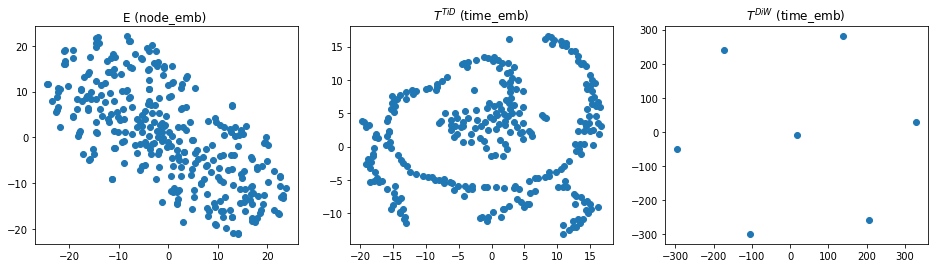

In [16]:
plot_emb(stid_model, model_type='paper')

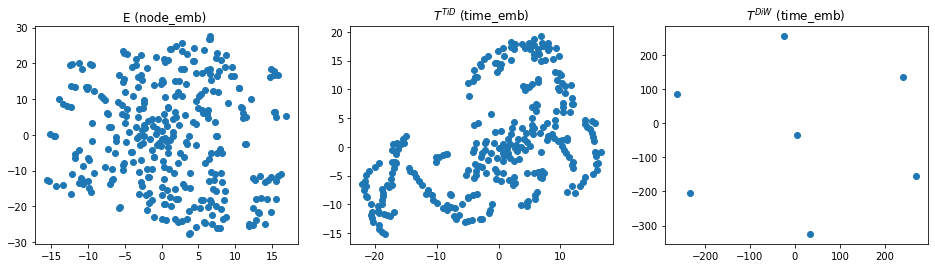

In [17]:
plot_emb(my_stid_model, model_type='my')